In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c data-science-bowl-2018

 99% 355M/358M [00:08<00:00, 34.3MB/s]
100% 358M/358M [00:08<00:00, 45.1MB/s]


In [4]:
!mkdir train test

In [5]:
!unzip /content/data-science-bowl-2018.zip 

Archive:  /content/data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [6]:
!unzip /content/stage1_train.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: /content/train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/

In [7]:
!unzip /content/stage1_test.zip -d /content/test

Archive:  /content/stage1_test.zip
   creating: /content/test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
   creating: /content/test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
   creating: /content/test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
   creating: /content/test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
   creating: /content/test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
   creating: /content/test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
   creating: /content/test/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
   creating: /content/test/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/
   creating: /content/test/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/
   creating: /content/test/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/
   creating: /content/test/1962d0c5

In [8]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 12.0 MB/s 
     |████████████████████████████████| 948 kB 47.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=f53a02325a27b7f642cec4fc11068b01ae940022ceda99c679539b28ae8384d9
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [9]:
import albumentations
albumentations.__version__

'0.4.6'

In [10]:
import os, time, copy, torch, shutil
from collections import defaultdict
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
from tqdm import tqdm as tqdm

from  albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize,
                             Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
train_path = '/content/train/'
test_path = '/content/test/'

In [12]:
lenTrain = len(os.listdir(train_path))
print("Total Train: {}".format(lenTrain))

lenTest = len(os.listdir(test_path))
print("Total Train: {}".format(lenTest))

Total Train: 670
Total Train: 65


In [13]:
def get_train_transform():
  return A.Compose([
                    A.Resize(256,256),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    A.HorizontalFlip(p=0.25),
                    A.VerticalFlip(p=0.25),
                    ToTensor()
  ])

In [14]:
#Dataset Loader
class LoadDataSet(Dataset):
        def __init__(self,path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = self.get_mask(mask_folder, 128, 128 ).astype('float32')

            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask[0].permute(2, 0, 1)
            return (img,mask) 


        def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1) #kenapa perlu diexpand?
                    mask = np.maximum(mask, mask_) #result dari maximumnya apa?
              
            return mask

In [15]:
train_dataset = LoadDataSet(train_path, transform=get_train_transform())

In [16]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [17]:
train_dataset.__len__()

670

In [18]:
image

tensor([[[-1.9044, -1.9054, -1.9075,  ..., -1.8931, -1.8863, -1.8829],
         [-1.9054, -1.9064, -1.9083,  ..., -1.8911, -1.8866, -1.8843],
         [-1.9076, -1.9084, -1.9100,  ..., -1.8872, -1.8871, -1.8871],
         ...,
         [-1.7144, -1.6396, -1.4898,  ..., -1.5987, -1.6587, -1.6887],
         [-1.5453, -1.4543, -1.2722,  ..., -1.4174, -1.5243, -1.5778],
         [-1.4608, -1.3617, -1.1634,  ..., -1.3268, -1.4572, -1.5223]],

        [[-1.8174, -1.8185, -1.8206,  ..., -1.8059, -1.7989, -1.7955],
         [-1.8185, -1.8195, -1.8215,  ..., -1.8039, -1.7992, -1.7969],
         [-1.8207, -1.8215, -1.8232,  ..., -1.7998, -1.7998, -1.7998],
         ...,
         [-1.6232, -1.5467, -1.3936,  ..., -1.5049, -1.5663, -1.5969],
         [-1.4504, -1.3573, -1.1711,  ..., -1.3196, -1.4289, -1.4835],
         [-1.3639, -1.2626, -1.0599,  ..., -1.2269, -1.3602, -1.4269]],

        [[-1.5871, -1.5882, -1.5903,  ..., -1.5756, -1.5687, -1.5653],
         [-1.5882, -1.5892, -1.5912,  ..., -1

In [19]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [20]:
def format_image(img):
  img = np.array(np.transpose(img, (1,2,0)))
  mean = np.array((0.485, 0.456, 0.406))
  std = np.array((0.229, 0.224, 0.225))
  img = std * img + mean
  img = img*255
  img = img.astype(np.uint8)
  return img

def format_mask(mask):
  mask = np.squeeze(np.transpose(mask, (1,2,0)))
  return mask

In [21]:
def visualize_dataset(n_images, predict=None):
  maxRange = train_dataset.__len__()
  images = random.sample(range(0, maxRange), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5,8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation='nearest', cmap='gray')
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

[238, 476, 265]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


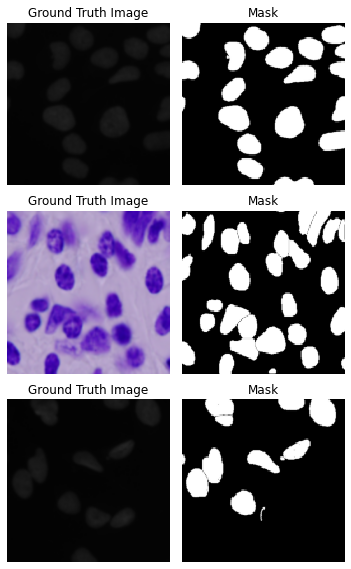

In [22]:
visualize_dataset(3)

In [23]:
train_data, valid_data = random_split(train_dataset, [469, 201])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

In [24]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )
    def forward(self,x):
      return self.conv_block(x) + self.conv_skip(x)

class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)



In [25]:
class ResUnet(nn.Module):
    def __init__(self, channel, filters=[16, 32, 64, 128, 256, 512, 1024]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)
        self.residual_conv_3 = ResidualConv(filters[2], filters[3], 2, 1)
        self.residual_conv_4 = ResidualConv(filters[3], filters[4], 2, 1)
        self.residual_conv_5 = ResidualConv(filters[4], filters[5], 2, 1)

        self.bridge = ResidualConv(filters[5], filters[6], 2, 1)

        self.upsample_1 = Upsample(filters[6], filters[6], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[6] + filters[5], filters[5], 1, 1)

        self.upsample_2 = Upsample(filters[5], filters[5], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[5] + filters[4], filters[4], 1, 1)

        self.upsample_3 = Upsample(filters[4], filters[4], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[4] + filters[3], filters[3], 1, 1)

        self.upsample_4 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv4 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_5 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv5 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_6 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv6 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        x4 = self.residual_conv_3(x3)
        x5 = self.residual_conv_4(x4)
        x6 = self.residual_conv_5(x5)
        # Bridge
        x7 = self.bridge(x6)
        # Decode
        x7 = self.upsample_1(x7)
        x8 = torch.cat([x7, x6], dim=1)

        x9 = self.up_residual_conv1(x8)
        
        x9 = self.upsample_2(x9)
        x10 = torch.cat([x9, x5], dim=1)

        x11 = self.up_residual_conv2(x10)
        
        x11 = self.upsample_3(x11)
        x12 = torch.cat([x11, x4], dim=1)

        x13 = self.up_residual_conv3(x12)

        x13 = self.upsample_4(x13)
        x14 = torch.cat([x13, x3], dim=1)

        x15 = self.up_residual_conv4(x14)

        x15 = self.upsample_5(x15)
        x16 = torch.cat([x15, x2], dim=1)

        x17 = self.up_residual_conv5(x16)

        x17 = self.upsample_6(x17)
        x18 = torch.cat([x17, x1], dim=1)

        x19 = self.up_residual_conv6(x18)

        output = self.output_layer(x19)

        return output

In [26]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [27]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
        
        return IoU

In [28]:
model = ResUnet(3).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [29]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
  f_path = checkpoint_path
  torch.save(state, f_path)
  if is_best:
    best_fpath = best_model_path
    shutil.copyfile(f_path, best_fpath)


In [30]:
def load_ckp(checkpoint_fpath, model, optimizer):
  checkpoint = torch.load(checkpoint_fpath)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  valid_loss_min = checkpoint['valid_loss_min']
  return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [31]:
weight_path = 'model_weight'
if not os.path.exists(weight_path):
  os.makedirs(weight_path)

In [32]:
#from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=20
valid_loss_min = np.Inf

checkpoint_path = 'model_weight/chkpoint_'
best_model_path = 'model_weight/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
  
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      #Loss
      loss = criterion(output, y_train)
      losses_value = loss.item()
      #Score
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      #train_score.append(score)
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## Compute Loss Value.
        loss = criterion(output, mask)
        losses_value = loss.item()
         ## Compute Accuracy Score
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    #Save best model Checkpoint
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    ## TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

description:   0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Epoch: 1, loss: 0.3094964027404785, IoU: 0.5273064970970154: 100%|██████████| 47/47 [06:22<00:00,  8.14s/it]



###############Train Loss: 0.5303607697182513, Train IOU: 0.31757745099194506###############
###############Valid Loss: 0.29123057354064213, Valid IOU: 0.5527611247130803###############
Validation loss decreased (inf --> 0.291231).  Saving model ...


Epoch: 2, loss: 0.15835058689117432, IoU: 0.7265943288803101: 100%|██████████| 47/47 [06:06<00:00,  7.80s/it]



###############Train Loss: 0.24330688917890508, Train IOU: 0.6133632932571654###############
###############Valid Loss: 0.20783560332797824, Valid IOU: 0.6592844611122495###############
Validation loss decreased (0.291231 --> 0.207836).  Saving model ...


Epoch: 3, loss: 0.14674484729766846, IoU: 0.7440686821937561: 100%|██████████| 47/47 [06:05<00:00,  7.79s/it]



###############Train Loss: 0.18649423122406006, Train IOU: 0.6883429859546905###############
###############Valid Loss: 0.2036156001545134, Valid IOU: 0.6659039556980133###############
Validation loss decreased (0.207836 --> 0.203616).  Saving model ...


Epoch: 4, loss: 0.22322851419448853, IoU: 0.6350188255310059: 100%|██████████| 47/47 [06:05<00:00,  7.78s/it]



###############Train Loss: 0.16749902354910018, Train IOU: 0.7154496261414062###############
###############Valid Loss: 0.17383178642817906, Valid IOU: 0.706246188708714###############
Validation loss decreased (0.203616 --> 0.173832).  Saving model ...


Epoch: 5, loss: 0.16616511344909668, IoU: 0.7150250673294067: 100%|██████████| 47/47 [06:04<00:00,  7.75s/it]



###############Train Loss: 0.1717148613422475, Train IOU: 0.7108697618575807###############
###############Valid Loss: 0.17917177506855556, Valid IOU: 0.6990702535424914###############


Epoch: 6, loss: 0.14435136318206787, IoU: 0.7477167248725891: 100%|██████████| 47/47 [06:02<00:00,  7.72s/it]



###############Train Loss: 0.1575428234769943, Train IOU: 0.7305246769113743###############
###############Valid Loss: 0.15561819360369727, Valid IOU: 0.7332930309431893###############
Validation loss decreased (0.173832 --> 0.155618).  Saving model ...


Epoch: 7, loss: 0.1892290711402893, IoU: 0.6817636489868164: 100%|██████████| 47/47 [06:02<00:00,  7.71s/it]



###############Train Loss: 0.14412186374055577, Train IOU: 0.7497697358435773###############
###############Valid Loss: 0.14420417376926967, Valid IOU: 0.7491514285405477###############
Validation loss decreased (0.155618 --> 0.144204).  Saving model ...


Epoch: 8, loss: 0.16909849643707275, IoU: 0.7107221484184265: 100%|██████████| 47/47 [06:01<00:00,  7.70s/it]



###############Train Loss: 0.14429122843640915, Train IOU: 0.7498609093909568###############
###############Valid Loss: 0.14269571928750902, Valid IOU: 0.7514471127873376###############
Validation loss decreased (0.144204 --> 0.142696).  Saving model ...


Epoch: 9, loss: 0.1258084774017334, IoU: 0.7765020728111267: 100%|██████████| 47/47 [06:01<00:00,  7.69s/it]



###############Train Loss: 0.14320152490697008, Train IOU: 0.7507879429675163###############
###############Valid Loss: 0.13718039932705106, Valid IOU: 0.7599994511831374###############
Validation loss decreased (0.142696 --> 0.137180).  Saving model ...


Epoch: 10, loss: 0.12640857696533203, IoU: 0.7755558490753174: 100%|██████████| 47/47 [06:05<00:00,  7.78s/it]



###############Train Loss: 0.13227846394193934, Train IOU: 0.7674675558475738###############
###############Valid Loss: 0.1374629537264506, Valid IOU: 0.760806279523032###############


Epoch: 11, loss: 0.15961742401123047, IoU: 0.7247083783149719: 100%|██████████| 47/47 [06:12<00:00,  7.93s/it]



###############Train Loss: 0.12881124907351554, Train IOU: 0.7726361409146735###############
###############Valid Loss: 0.14076003006526402, Valid IOU: 0.7544801604180109###############


Epoch: 12, loss: 0.1573449969291687, IoU: 0.7280954122543335: 100%|██████████| 47/47 [06:18<00:00,  8.05s/it]



###############Train Loss: 0.1338086800372347, Train IOU: 0.7654368179909726###############
###############Valid Loss: 0.13139702592577254, Valid IOU: 0.7688945787293571###############
Validation loss decreased (0.137180 --> 0.131397).  Saving model ...


Epoch: 13, loss: 0.1549798846244812, IoU: 0.7316327095031738: 100%|██████████| 47/47 [06:16<00:00,  8.01s/it]



###############Train Loss: 0.12817856606016767, Train IOU: 0.773961215577227###############
###############Valid Loss: 0.1291720952306475, Valid IOU: 0.7726678138687497###############
Validation loss decreased (0.131397 --> 0.129172).  Saving model ...


Epoch: 14, loss: 0.0855826735496521, IoU: 0.8423294425010681: 100%|██████████| 47/47 [06:20<00:00,  8.10s/it]



###############Train Loss: 0.12531566239417868, Train IOU: 0.7787836916903232###############
###############Valid Loss: 0.12959792500450498, Valid IOU: 0.7717816687765575###############


Epoch: 15, loss: 0.105191171169281, IoU: 0.8096433877944946: 100%|██████████| 47/47 [06:19<00:00,  8.08s/it]



###############Train Loss: 0.12470407435234557, Train IOU: 0.7790609255750128###############
###############Valid Loss: 0.131605293069567, Valid IOU: 0.7683143984703791###############


Epoch: 16, loss: 0.1148902177810669, IoU: 0.7938997149467468: 100%|██████████| 47/47 [06:17<00:00,  8.03s/it]



###############Train Loss: 0.1253324988040518, Train IOU: 0.7787017454492285###############
###############Valid Loss: 0.12898109356562296, Valid IOU: 0.7735400313422793###############
Validation loss decreased (0.129172 --> 0.128981).  Saving model ...


Epoch: 17, loss: 0.18881767988204956, IoU: 0.6823456287384033: 100%|██████████| 47/47 [06:22<00:00,  8.14s/it]



###############Train Loss: 0.14649769346764746, Train IOU: 0.7467682640603248###############
###############Valid Loss: 0.16202690771647862, Valid IOU: 0.7234697796049572###############


Epoch: 18, loss: 0.12599432468414307, IoU: 0.7762090563774109: 100%|██████████| 47/47 [06:18<00:00,  8.05s/it]



###############Train Loss: 0.13645277632043717, Train IOU: 0.7612734411625152###############
###############Valid Loss: 0.14579950343994869, Valid IOU: 0.7478607949756441###############


Epoch: 19, loss: 0.15378236770629883, IoU: 0.7334304451942444: 100%|██████████| 47/47 [06:23<00:00,  8.16s/it]



###############Train Loss: 0.1369591127050684, Train IOU: 0.7604917871191147###############
###############Valid Loss: 0.13704093864985875, Valid IOU: 0.7604717158135914###############


Epoch: 20, loss: 0.23031020164489746, IoU: 0.6256096363067627: 100%|██████████| 47/47 [07:03<00:00,  9.02s/it]



###############Train Loss: 0.1264916480855739, Train IOU: 0.7768368403962318###############
###############Valid Loss: 0.12829204684212095, Valid IOU: 0.7738324233463832###############
Validation loss decreased (0.128981 --> 0.128292).  Saving model ...


<Figure size 432x288 with 0 Axes>

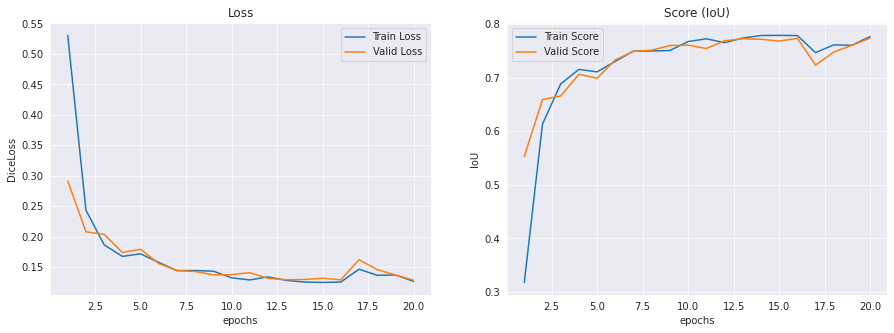

In [35]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15, 5))
sns.set_style(style='darkgrid')
plt.subplot(1, 2, 1)
sns.lineplot(x= range(1, 21), y=total_train_loss, label='Train Loss')
sns.lineplot(x= range(1, 21), y=total_valid_loss, label='Valid Loss')
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 21), y=total_train_score, label='Train Score')
sns.lineplot(x=range(1, 21), y=total_valid_score, label='Valid Score')
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

In [41]:
##Validating Model
#loading to save model
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [44]:
def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in val_loader:
        data = torch.autograd.Variable(data, volatile=True).cuda()
        mask = torch.autograd.Variable(mask, volatile=True).cuda()
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


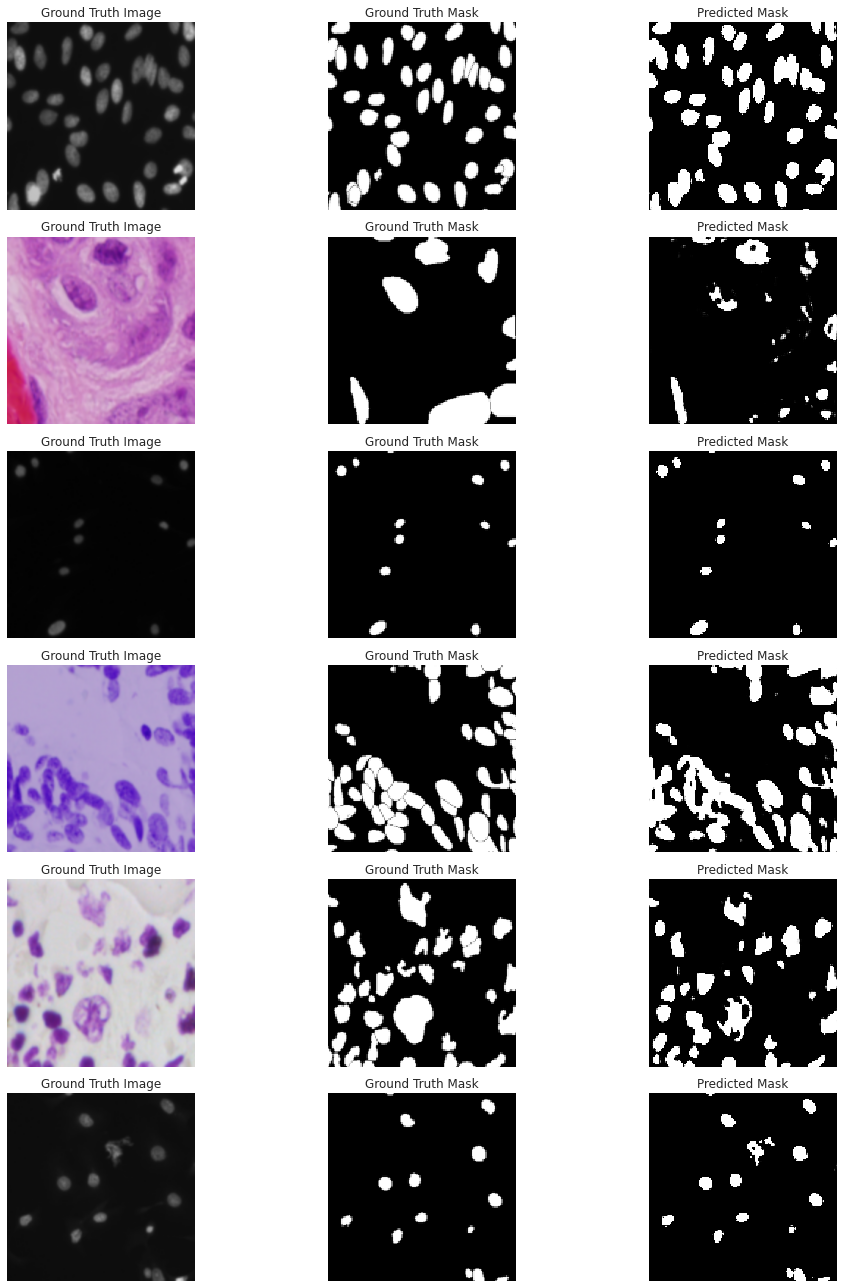

In [45]:
visualize_predict(model, 6)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
!cp /content/model_weight/bestmodel.pt /content/drive/MyDrive